#  **Basic Setup installing libraries& getting the data**

In [106]:
!pip install torch torchvision matplotlib tqdm pillow==11.0.0 -qU

In [ ]:
!git clone https://github.com/EyadAlN3imi/DS372-Forensics.git 

fatal: destination path 'DS372-Forensics' already exists and is not an empty directory.


In [108]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.express as px
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, pairwise_distances
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torchvision import transforms
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway
from PIL import Image, ImageOps
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [109]:
data_path = "/content/DS372-Forensics/Datasets/BPA_DATA"
os.listdir(data_path)

['FINAL_ALL_DATA.csv', 'FINAL_ALL_IMAGES']

In [110]:
df = pd.read_csv('/content/DS372-Forensics/Datasets/BPA_DATA/FINAL_ALL_DATA.csv')
df

,image_name,class,source_dataset
0,C1_beat.jpg,beating,beating
1,C10_beat.jpg,beating,beating
2,C11_beat.jpg,beating,beating
3,C12_beat.jpg,beating,beating
4,C2_beat.jpg,beating,beating
...,...,...,...
326,9-675.jpg,blood drip,paper75
327,9-775.jpg,blood drip,paper75
328,9-875.jpg,blood drip,paper75
329,9-975.jpg,blood drip,paper75


In [111]:
img_dir = os.path.join(data_path, "FINAL_ALL_IMAGES")
total_size_bytes = 0
for img_name in df['image_name']:
    img_path = os.path.join(img_dir, img_name)
    if os.path.exists(img_path):
        total_size_bytes += os.path.getsize(img_path)

total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total images storage size: {total_size_mb:.2f} MB")

Total images storage size: 16.55 MB


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_name      331 non-null    object
 1   class           331 non-null    object
 2   source_dataset  331 non-null    object
dtypes: object(3)
memory usage: 7.9+ KB


In [113]:
freq_table = pd.DataFrame({
    'Count': df['class'].value_counts(),
    'Percentage': df['class'].value_counts(normalize=True) * 100
})

freq_table['Cumulative %'] = freq_table['Percentage'][::-1].cumsum()[::-1].round(2)
freq_table['Percentage'] = freq_table['Percentage'].round(2)

freq_table

,Count,Percentage,Cumulative %
class,,,
blood drip,202,61.03,100.00
gun shot,68,20.54,38.97
beating,61,18.43,18.43


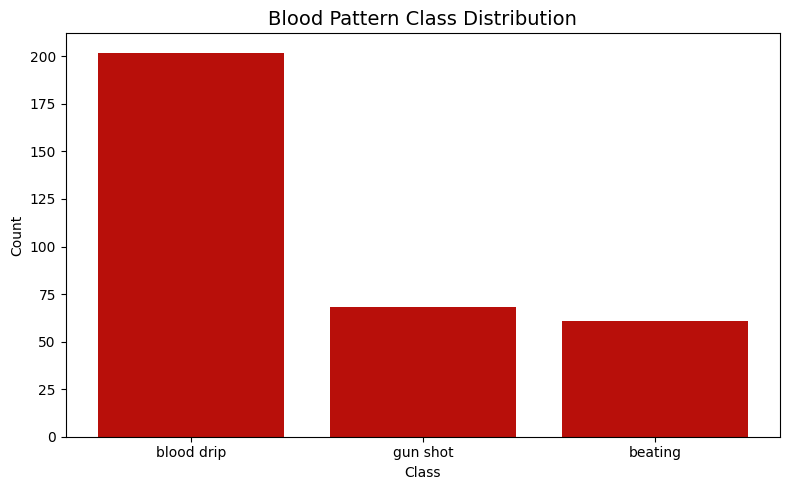

In [114]:
counts = df['class'].value_counts()

plt.figure(figsize=(8, 5))

plt.bar(counts.index, counts.values, color="#B80F0A")

plt.title("Blood Pattern Class Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()

plt.show()

1.5.GLOBAL COLOR CONFIGURATION

In [115]:
unique_classes = sorted(df['class'].unique())

palette = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']

class_colors = {cls: palette[i % len(palette)] for i, cls in enumerate(unique_classes)}

print("Global Color Map Assigned:")
for cls, color in class_colors.items():
    print(f"  {cls}: {color}")

Global Color Map Assigned:
  beating: #636EFA
  blood drip: #EF553B
  gun shot: #00CC96


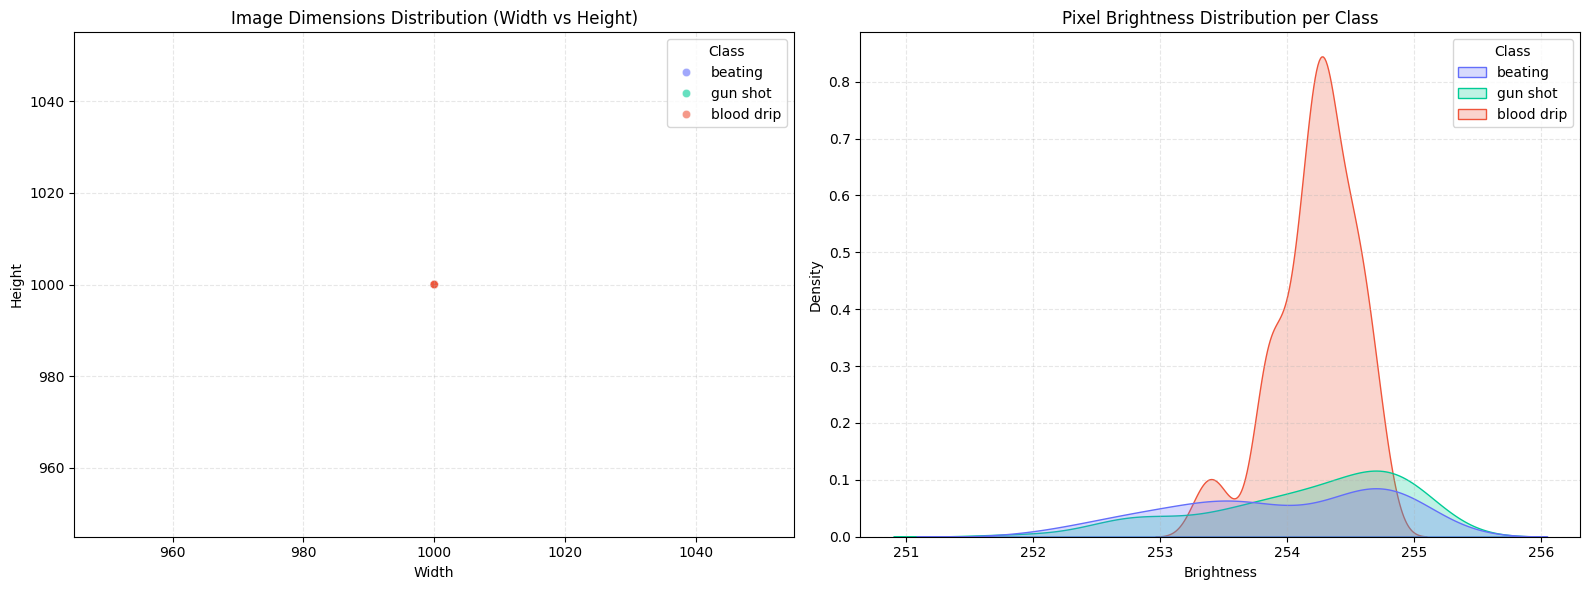

             Width  Height  Aspect Ratio  Brightness
Class                                               
beating     1000.0  1000.0           1.0      253.94
blood drip  1000.0  1000.0           1.0      254.23
gun shot    1000.0  1000.0           1.0      254.14


In [116]:
image_stats = []

for idx, row in df.iterrows():
    img_path = os.path.join(img_dir, row['image_name'])

    try:
        img = cv2.imread(img_path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        height, width, _ = img.shape
        mean_brightness = np.mean(img_rgb)
        aspect_ratio = width / height

        image_stats.append({
            'Class': row['class'],
            'Width': width,
            'Height': height,
            'Aspect Ratio': aspect_ratio,
            'Brightness': mean_brightness
        })
    except:
        continue

df_stats = pd.DataFrame(image_stats)

if not df_stats.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.scatterplot(data=df_stats, x='Width', y='Height', hue='Class', palette=class_colors, alpha=0.6, ax=axes[0])
    axes[0].set_title("Image Dimensions Distribution (Width vs Height)")
    axes[0].grid(True, linestyle='--', alpha=0.3)

    sns.kdeplot(data=df_stats, x='Brightness', hue='Class', fill=True, palette=class_colors, ax=axes[1])
    axes[1].set_title("Pixel Brightness Distribution per Class")
    axes[1].grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(df_stats.groupby('Class')[['Width', 'Height', 'Aspect Ratio', 'Brightness']].mean().round(2))

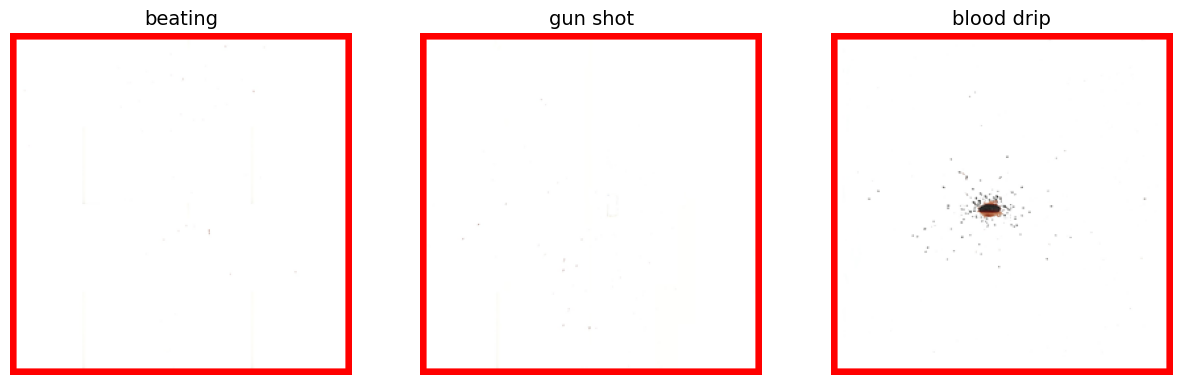

In [117]:
img_dir = os.path.join(data_path, "FINAL_ALL_IMAGES")

classes = df['class'].unique()

fig, ax = plt.subplots(1, len(classes), figsize=(5 * len(classes), 6))

for i, cls in enumerate(classes):
    subset = df[df['class'] == cls]
    img_name = subset.sample(1)['image_name'].values[0]
    path = os.path.join(img_dir, img_name)

    img = Image.open(path).resize((250, 250))

    img = ImageOps.expand(img, border=5, fill="red")

    ax[i].imshow(img)
    ax[i].set_title(cls, fontsize=14)
    ax[i].axis("off")

plt.subplots_adjust(wspace=0.2)
plt.show()


In [118]:
dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

def get_dino_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        emb = dino_model(img)
    return emb.cpu().numpy().flatten()

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


In [119]:
embeddings = []
labels = []

print(f"Processing {len(df)} images...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(img_dir, row['image_name'])
    label = row['class']

    emb = get_dino_embedding(img_path)
    embeddings.append(emb)
    labels.append(label)

embeddings = np.array(embeddings)
labels = np.array(labels)

print(f"\nEmbeddings extracted")
print(f"  - Shape: {embeddings.shape}")
print(f"  - Embedding dimension: {embeddings.shape[1]}")

Processing 331 images...


100%|██████████| 331/331 [01:46<00:00,  3.11it/s]


Embeddings extracted
  - Shape: (331, 384)
  - Embedding dimension: 384


In [120]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

print(f"✓ Features normalized")
print(f"  - Shape: {X_scaled.shape}")
print(f"  - Mean: {X_scaled.mean(axis=0)[:5]}...")
print(f"  - Std: {X_scaled.std(axis=0)[:5]}...")

✓ Features normalized
  - Shape: (331, 384)
  - Mean: [ 3.2413403e-09 -3.1513029e-08  8.9677080e-08 -2.3330896e-08
  1.1668825e-07]...
  - Std: [1.         1.0000001  1.0000001  0.99999976 1.0000001 ]...


In [121]:
tsne = TSNE(
    n_components=3,
    learning_rate='auto',
    init='pca',
    perplexity=15,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

print(f"t-SNE - Shape: {X_tsne.shape}")

t-SNE - Shape: (331, 3)


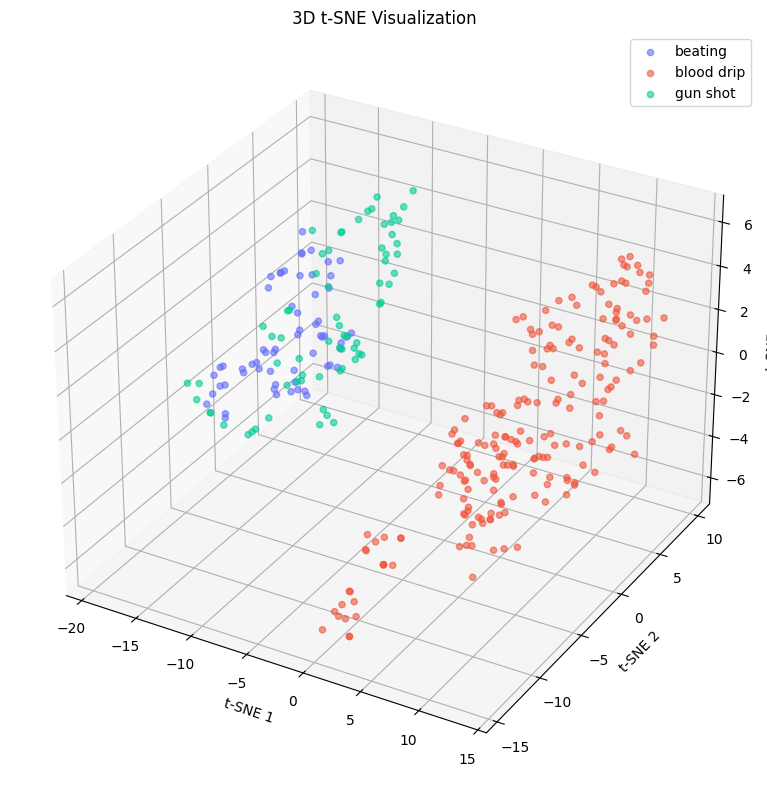

In [122]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(labels):
    mask = labels == label
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], X_tsne[mask, 2],
               c=class_colors[label],
               label=label,
               s=20,
               alpha=0.6)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.set_title('3D t-SNE Visualization')
ax.legend()

plt.tight_layout()
plt.show()

In [123]:
fig = px.scatter_3d(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    z=X_tsne[:, 2],
    color=labels,
    title="3D t-SNE Visualization",
    labels={
        "x": "t-SNE 1",
        "y": "t-SNE 2",
        "z": "t-SNE 3",
        "color": "Class"
    },
    color_discrete_map=class_colors
)

fig.update_traces(marker=dict(size=4))
fig.show()

In [124]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)[-1]

fig = go.Figure()

unique_labels = np.unique(labels)

for label in unique_labels:
    mask = (labels == label)
    points = X_pca[mask]

    color = class_colors[label]

    center = np.mean(points, axis=0)

    fig.add_trace(go.Scatter3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2],
        mode='markers',
        marker=dict(size=4, color=color),
        name=label,
        showlegend=True
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, center[0]], y=[0, center[1]], z=[0, center[2]],
        mode='lines',
        line=dict(color=color, width=5),
        showlegend=False,
        hoverinfo='skip'
    ))

    fig.add_trace(go.Cone(
        x=[center[0]], y=[center[1]], z=[center[2]],
        u=[center[0]], v=[center[1]], w=[center[2]],
        anchor="tip",
        sizemode="absolute",
        sizeref=0.5,
        showscale=False,
        colorscale=[[0, color], [1, color]],
        hoverinfo='skip',
        showlegend=False
    ))

fig.update_layout(
    title=f"3D PCA with Class Vectors (Cumulative Variance: {cumulative_variance:.2%})",
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    legend_title="Class",
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

In [125]:
mean_vectors = []
class_stats = []

for label in unique_labels:
    mask = (labels == label)
    class_data = X_scaled[mask]

    centroid = np.mean(class_data, axis=0)
    mean_vectors.append(centroid)

    spread = np.mean(np.std(class_data, axis=0))

    class_stats.append({
        'Class': label,
        'Avg Variance (Spread)': spread
    })

mean_vectors_array = np.array(mean_vectors)
stats_df = pd.DataFrame(class_stats)

print("## Class Centroids Extraction Complete")
print(f"Shape of Mean Vectors: {mean_vectors_array.shape}")
print("\n## Class Spread Statistics")
print(stats_df.to_markdown(index=False))

## Class Centroids Extraction Complete
Shape of Mean Vectors: (3, 384)

## Class Spread Statistics
| Class      |   Avg Variance (Spread) |
|:-----------|------------------------:|
| beating    |                0.814311 |
| blood drip |                0.829755 |
| gun shot   |                0.941663 |


## Similarity Heatmap (Alignment of Mean Vectors)


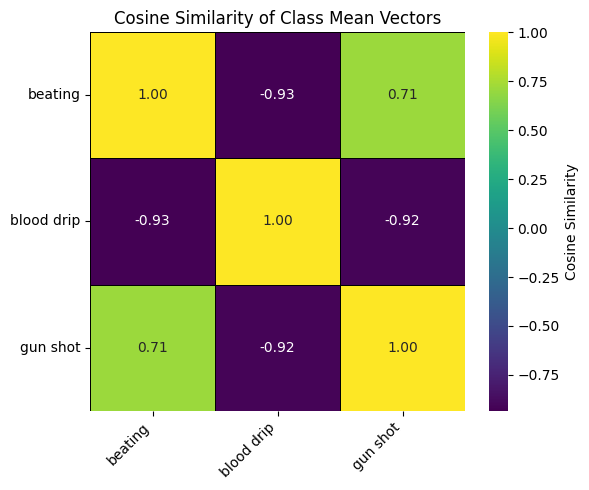

In [126]:
corr_matrix = cosine_similarity(mean_vectors_array)
corr_df = pd.DataFrame(corr_matrix, index=unique_labels, columns=unique_labels)
print("## Similarity Heatmap (Alignment of Mean Vectors)")

plt.figure(figsize=(6, 5))
sns.heatmap(corr_df, annot=True, cmap="viridis", fmt=".2f", linewidths=.5, linecolor='black', cbar_kws={'label': 'Cosine Similarity'})
plt.title("Cosine Similarity of Class Mean Vectors")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("correlation_heatmap.png")

In [127]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, labels)

print(f"LDA transformation complete.")
print(f"  - Original Shape: {X_scaled.shape}")
print(f"  - LDA Shape: {X_lda.shape}")

fig = px.scatter(
    x=X_lda[:, 0],
    y=X_lda[:, 1],
    color=labels,
    title="2D LDA Visualization of Blood Patterns",
    labels={
        "x": "LDA Component 1",
        "y": "LDA Component 2",
        "color": "Class"
    },
    opacity=0.8,
    color_discrete_map=class_colors
)

fig.update_traces(marker=dict(size=6))
fig.show()

LDA transformation complete.
  - Original Shape: (331, 384)
  - LDA Shape: (331, 2)


Global Silhouette Score: 0.1824


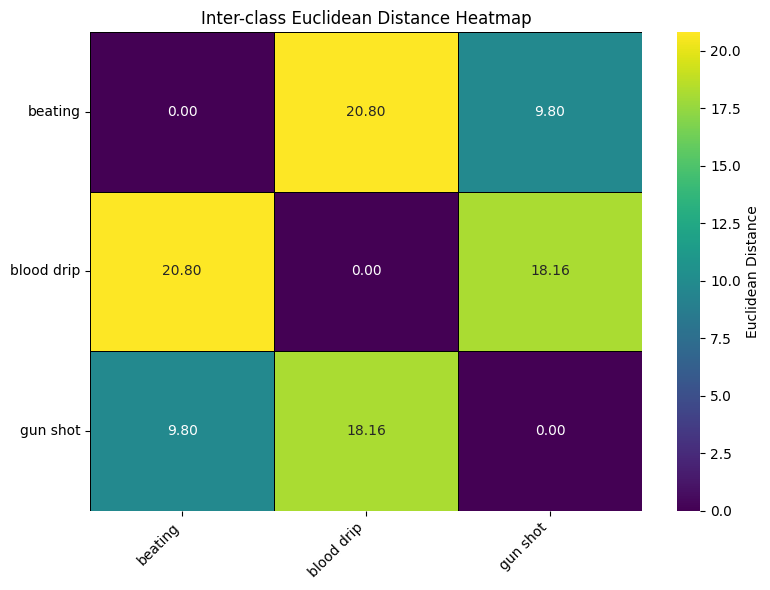

In [128]:
sil_score = silhouette_score(X_scaled, labels)
print(f"Global Silhouette Score: {sil_score:.4f}")

centroids = []
for cls in unique_classes:
    mask = labels == cls
    centroids.append(X_scaled[mask].mean(axis=0))

centroids = np.array(centroids)

dist_matrix = pairwise_distances(centroids)
df_dist = pd.DataFrame(dist_matrix, index=unique_classes, columns=unique_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(df_dist,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            linewidths=0.5,
            linecolor='black',
            cbar_kws={'label': 'Euclidean Distance'})

plt.title("Inter-class Euclidean Distance Heatmap")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

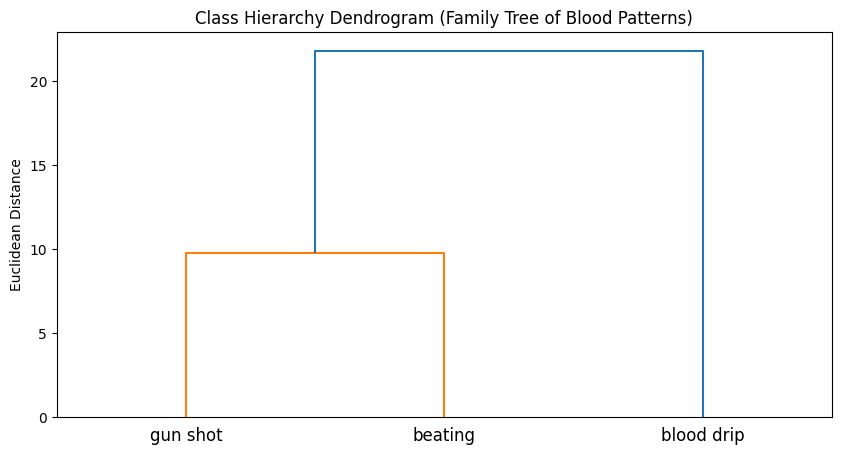

In [129]:
centroids = np.array([X_scaled[labels == cls].mean(axis=0) for cls in unique_classes])

linked = linkage(centroids, 'ward')

plt.figure(figsize=(10, 5))
plt.title('Class Hierarchy Dendrogram (Family Tree of Blood Patterns)')
dendrogram(linked,
           labels=unique_classes,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.ylabel('Euclidean Distance')
plt.show()

--- Investigating Overlap: Beating vs Gun shot ---
Found 9 hard samples in 'beating' looks like 'gun shot'


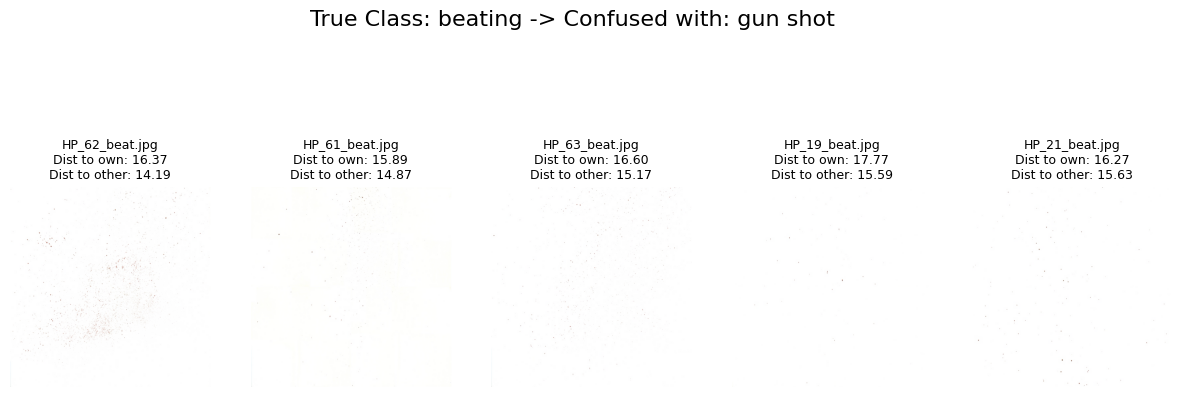

Found 10 hard samples in 'gun shot' looks like 'beating'


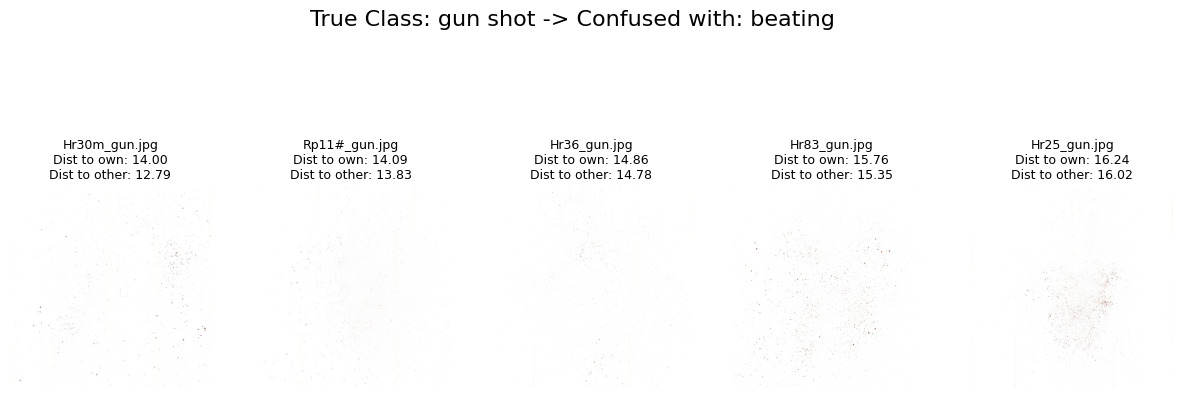

In [130]:
def visualize_hard_samples(class_a, class_b, embeddings, labels, df, img_dir, num_show=5):
    idxs_a = np.where(labels == class_a)[0]
    idxs_b = np.where(labels == class_b)[0]

    centroid_a = embeddings[idxs_a].mean(axis=0).reshape(1, -1)
    centroid_b = embeddings[idxs_b].mean(axis=0).reshape(1, -1)

    dists_a_to_own = cdist(embeddings[idxs_a], centroid_a).flatten()
    dists_a_to_other = cdist(embeddings[idxs_a], centroid_b).flatten()

    hard_idxs_a = idxs_a[dists_a_to_other < dists_a_to_own]

    hard_idxs_a = hard_idxs_a[np.argsort(dists_a_to_other[dists_a_to_other < dists_a_to_own])]

    print(f"Found {len(hard_idxs_a)} hard samples in '{class_a}' looks like '{class_b}'")

    if len(hard_idxs_a) > 0:
        fig, axes = plt.subplots(1, min(num_show, len(hard_idxs_a)), figsize=(15, 5))
        if num_show == 1: axes = [axes]

        fig.suptitle(f"True Class: {class_a} -> Confused with: {class_b}", fontsize=16, y=1.05)

        for i, idx in enumerate(hard_idxs_a[:num_show]):
            img_name = df.iloc[idx]['image_name']
            img_path = os.path.join(img_dir, img_name)

            try:
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].set_title(f"{img_name}\nDist to own: {dists_a_to_own[np.where(idxs_a==idx)[0][0]]:.2f}\nDist to other: {dists_a_to_other[np.where(idxs_a==idx)[0][0]]:.2f}", fontsize=9)
                axes[i].axis('off')
            except Exception as e:
                print(f"Could not read image {img_name}: {e}")
        plt.show()
    else:
        print(f"No hard samples found for {class_a} confused with {class_b}!")

print("--- Investigating Overlap: Beating vs Gun shot ---")
visualize_hard_samples('beating', 'gun shot', X_scaled, labels, df, img_dir)
visualize_hard_samples('gun shot', 'beating', X_scaled, labels, df, img_dir)

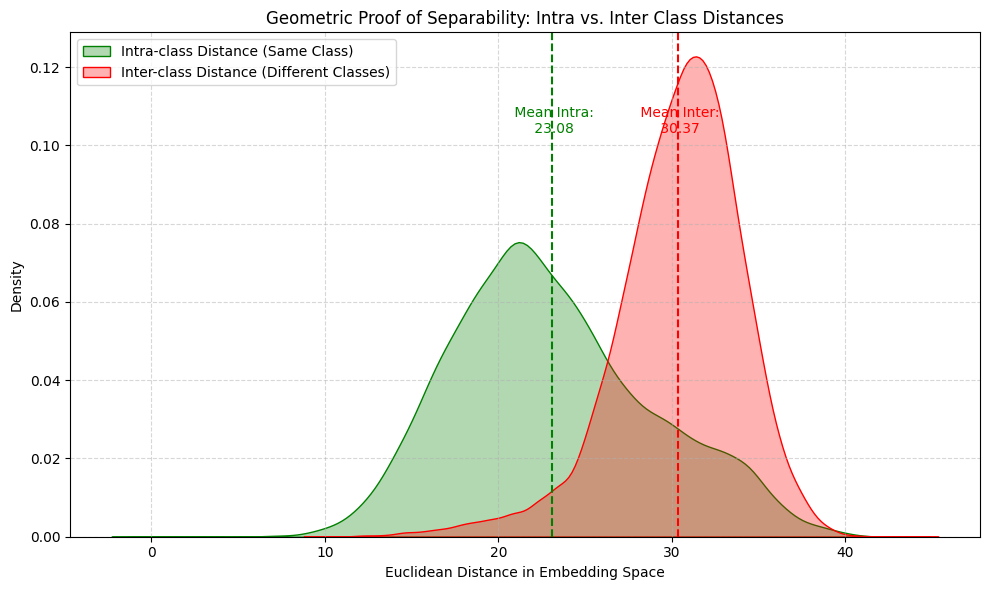

In [131]:
dist_matrix = squareform(pdist(X_scaled, metric='euclidean'))

intra_dists = []
inter_dists = []

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        d = dist_matrix[i, j]
        if labels[i] == labels[j]:
            intra_dists.append(d)
        else:
            inter_dists.append(d)

plt.figure(figsize=(10, 6))
sns.kdeplot(intra_dists, fill=True, color='green', label='Intra-class Distance (Same Class)', alpha=0.3)
sns.kdeplot(inter_dists, fill=True, color='red', label='Inter-class Distance (Different Classes)', alpha=0.3)

plt.title("Geometric Proof of Separability: Intra vs. Inter Class Distances")
plt.xlabel("Euclidean Distance in Embedding Space")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

mean_intra = np.mean(intra_dists)
mean_inter = np.mean(inter_dists)
plt.axvline(mean_intra, color='green', linestyle='--')
plt.axvline(mean_inter, color='red', linestyle='--')
plt.text(mean_intra, plt.ylim()[1]*0.8, f' Mean Intra:\n {mean_intra:.2f}', color='green', ha='center')
plt.text(mean_inter, plt.ylim()[1]*0.8, f' Mean Inter:\n {mean_inter:.2f}', color='red', ha='center')

plt.tight_layout()
plt.show()

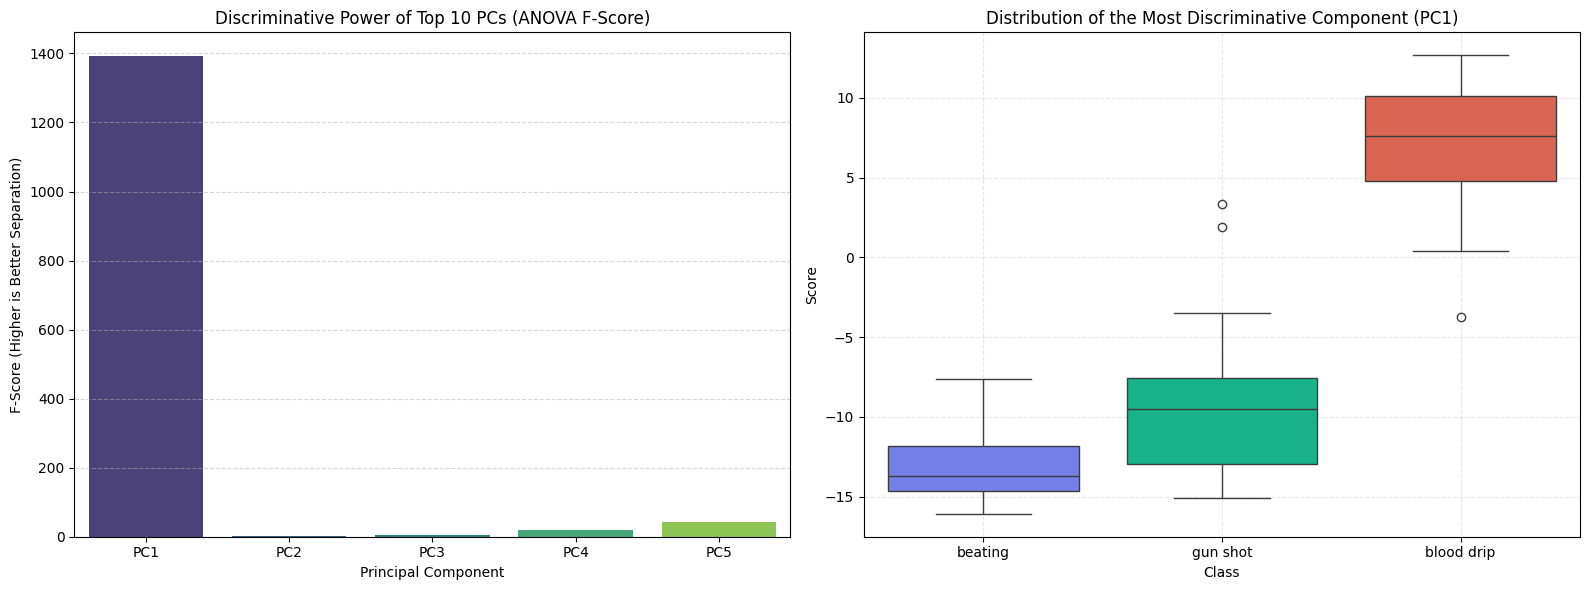

In [ ]:
pca_10 = PCA(n_components=5)
X_pca_10 = pca_10.fit_transform(X_scaled)

f_scores = []
for i in range(5):
    pc_data = X_pca_10[:, i]
    groups = [pc_data[labels == cls] for cls in unique_classes]
    f_stat, p_val = f_oneway(*groups)
    f_scores.append(f_stat)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=[f"PC{i+1}" for i in range(5)], y=f_scores, ax=axes[0], palette="viridis")
axes[0].set_title("Discriminative Power of Top 5 PCs (ANOVA F-Score)")
axes[0].set_ylabel("F-Score (Higher is Better Separation)")
axes[0].set_xlabel("Principal Component")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

best_pc_idx = np.argmax(f_scores)
best_pc_name = f"PC{best_pc_idx+1}"

df_best_pc = pd.DataFrame({
    'Score': X_pca_10[:, best_pc_idx],
    'Class': labels
})

sns.boxplot(data=df_best_pc, x='Class', y='Score', hue='Class', palette=class_colors, ax=axes[1], dodge=False)
axes[1].set_title(f"Distribution of the Most Discriminative Component ({best_pc_name})")
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()